In [2]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, median_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

sns.set_style('darkgrid')
sns.set_context('notebook')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 数据加载
def parse_date_fuc(x):
    result = datetime.datetime.strptime(x, "%Y %m %d %H")
    return result

In [4]:
df = pd.read_csv("F:/BI/第17周/L9/pm2.5/raw.csv",
                 index_col=0,
                 parse_dates=[['year', 'month', 'day', 'hour']], # 组合4列，并将其解析为单个日期列
                 date_parser=parse_date_fuc) # 解析日期

In [5]:
df

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,43820,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,43821,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,43822,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [6]:
df.index.name = 'date'

In [7]:
df.index.min(), df.index.max()

(Timestamp('2010-01-01 00:00:00'), Timestamp('2014-12-31 23:00:00'))

2010年到2014年共5年的数据。

In [8]:
df.loc['2010']

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...
2010-12-31 19:00:00,8756,27.0,-20,-5.0,1030.0,NW,534.65,0,0
2010-12-31 20:00:00,8757,17.0,-20,-6.0,1031.0,NW,543.59,0,0
2010-12-31 21:00:00,8758,19.0,-21,-6.0,1031.0,NW,552.53,0,0


In [9]:
# 数据清洗
df.drop(columns="No", inplace=True)

In [11]:
# 修改列名
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'cum_snow', 'cum_rain']
df

,pollution,dew,temp,press,wnd_dir,wnd_spd,cum_snow,cum_rain
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [12]:
# 缺失值
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  41757 non-null  float64
 1   dew        43824 non-null  int64  
 2   temp       43824 non-null  float64
 3   press      43824 non-null  float64
 4   wnd_dir    43824 non-null  object 
 5   wnd_spd    43824 non-null  float64
 6   cum_snow   43824 non-null  int64  
 7   cum_rain   43824 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


In [13]:
mask = df['pollution'].isna()
print("pollution列缺失值占比为 %.2f%%" % (mask.sum() / len(mask) * 100))
print("缺失值日期  小时数")
pd.Series(df.loc[mask, 'pollution'].index.date).value_counts().sort_index()

pollution列缺失值占比为 4.72%
缺失值日期  小时数


2010-01-01    24
2010-01-23     7
2010-01-24    24
2010-01-25    24
2010-01-26    12
              ..
2014-11-21     9
2014-12-05     2
2014-12-08     6
2014-12-09    11
2014-12-20     9
Length: 255, dtype: int64

In [14]:
# 可视化
def plot_polution(df, ax, year='2010'):
    """绘制一年的PM2.5变动情况"""
    year_df = df.loc[year, ['pollution']]
    # 按PM2.5的分级标准进行分桶：优、良、轻度、中度污染、重度污染、严重污染
    year_df['group'] = pd.cut(year_df['pollution'], bins=[-np.inf, 35, 75, 115, 150, 250, np.inf], labels=range(6))
    # 优、良、轻度、中度污染、重度污染、严重污染
    # 对应颜色：绿色、中海绿色、黄色、橙色、红色、深红色
    colors = ['green', 'mediumseagreen', 'yellow', 'orange', 'red', 'darkred']
    colors = year_df['group'].apply(lambda x: colors[x])
    ax.scatter(x=year_df.index,
               y=year_df['pollution'].values,
               color=colors.values,
               marker='+')
    ax.set_ylabel('PM2.5')
    # 统一坐标轴刻度
    ax.set_ylim(0, 1e3)
    if year == '2010':
        ax.set_title("PM2.5级别与颜色: 优:绿色, 良:中海绿色, 轻度:黄色, 中度:橙色, 重度:红色, 严重:深红色")
    if year == '2014':
        ax.set_xlabel('Date')

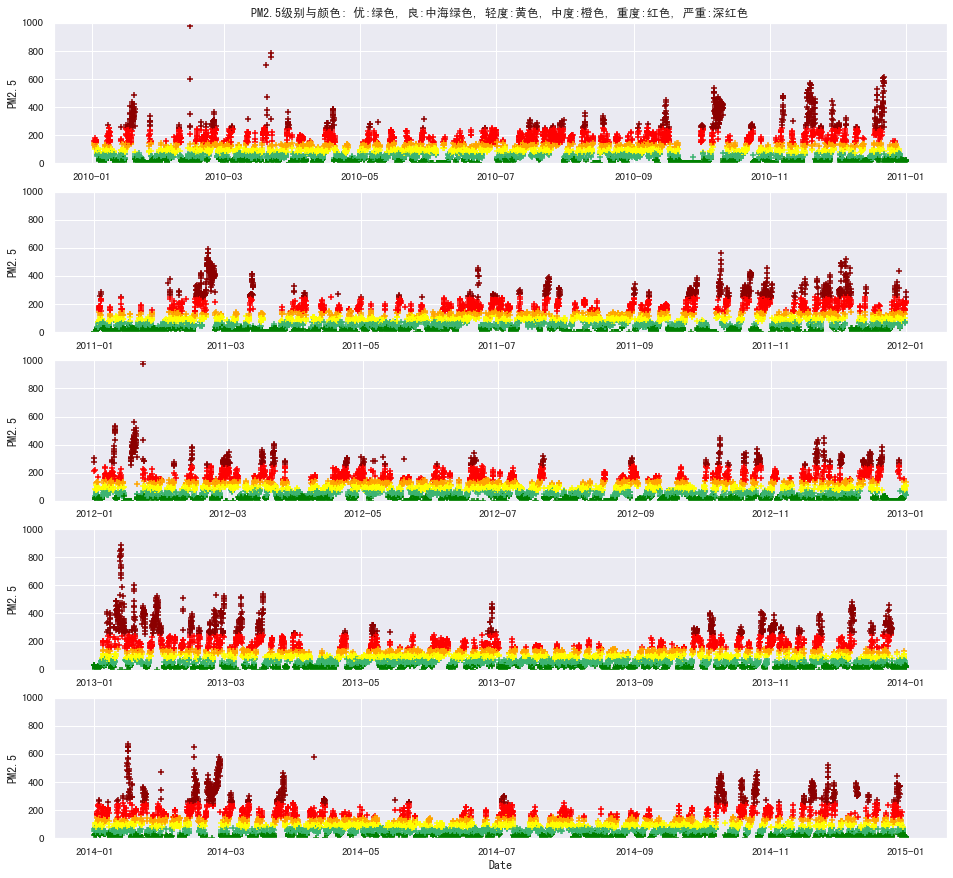

In [15]:
# 每年PM2.5变动情况
fig, axes = plt.subplots(5, 1, figsize=(16, 15))
for i in range(5):
    plot_polution(df, axes[i], year='201%d' % i)
plt.show()

1.全天PM2.5水平均处在优或良水平的天数很少。

2.严重污染多出现在每年的1-3月、7月、10-12月，说明与较冷的天气有关系，同时也与碳排放量有关。

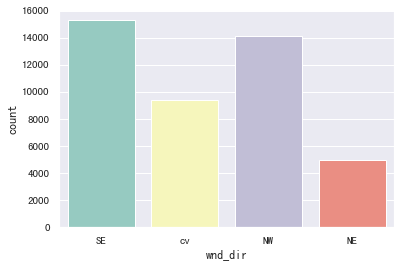

In [16]:
# wnd_dir列数值化
sns.countplot(data=df, x='wnd_dir', palette="Set3")

In [17]:
df['wnd_dir']

date
2010-01-02 00:00:00    SE
2010-01-02 01:00:00    SE
2010-01-02 02:00:00    SE
2010-01-02 03:00:00    SE
2010-01-02 04:00:00    SE
                       ..
2014-12-31 19:00:00    NW
2014-12-31 20:00:00    NW
2014-12-31 21:00:00    NW
2014-12-31 22:00:00    NW
2014-12-31 23:00:00    NW
Name: wnd_dir, Length: 43800, dtype: object

In [18]:
transfer = LabelEncoder()
df['wnd_dir'] = transfer.fit_transform(df['wnd_dir'])
# label 0 1 2 3对应含义
transfer.classes_

array(['NE', 'NW', 'SE', 'cv'], dtype=object)

In [26]:
# EDA
df['cum_snow'].describe()

count    43800.000000
mean         0.052763
std          0.760582
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         27.000000
Name: cum_snow, dtype: float64

In [27]:
df['cum_rain'].describe()

count    43800.000000
mean         0.195023
std          1.416247
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         36.000000
Name: cum_rain, dtype: float64

In [28]:
# 相关系数可视化
def sort_corr(corr_df, target_col='pollution'):
    """按与目标列相关系数垂直由低到高、水平由高到低对相关系数矩阵重新排序"""
    tmp = corr_df.copy()
    tmp = tmp.sort_values(by=target_col, ascending=True)
    sort_cols = tmp.index.tolist()
    tmp = tmp.loc[:, sort_cols[::-1]]
    return tmp

In [29]:
corr_df = df.corr()
corr_df

,pollution,dew,temp,press,wnd_dir,wnd_spd,cum_snow,cum_rain
pollution,1.000000,0.157585,-0.090798,-0.045544,0.187459,-0.234362,0.022226,-0.049045
dew,0.157585,1.000000,0.824432,-0.778737,0.232960,-0.296720,-0.034484,0.125053
temp,-0.090798,0.824432,1.000000,-0.827205,0.175626,-0.154902,-0.092726,0.049037
press,-0.045544,-0.778737,-0.827205,1.000000,-0.168986,0.185380,0.069031,-0.079840
wnd_dir,0.187459,0.232960,0.175626,-0.168986,1.000000,-0.200031,0.010356,-0.048323
wnd_spd,-0.234362,-0.296720,-0.154902,0.185380,-0.200031,1.000000,0.021876,-0.010137
cum_snow,0.022226,-0.034484,-0.092726,0.069031,0.010356,0.021876,1.000000,-0.009553
cum_rain,-0.049045,0.125053,0.049037,-0.079840,-0.048323,-0.010137,-0.009553,1.000000


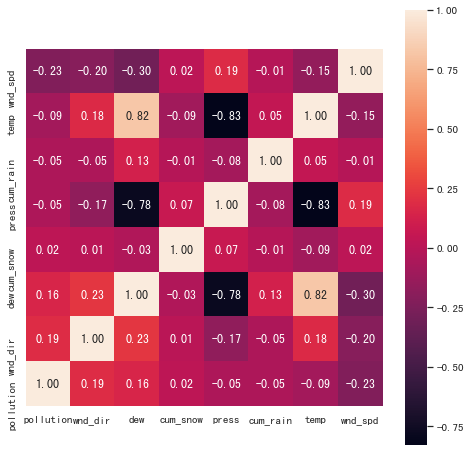

In [30]:
plt.figure(figsize=(8, 8))
sns.heatmap(sort_corr(corr_df), annot=True, square=True, fmt='.2f')

没有到相关系数±0.9的特征，暂保留所有特征。

准备训练集和测试集

In [31]:
# 无量纲化
scaled_df = df.copy()
# 只对前8列作为特征的列进行无量纲化
transfer2 = StandardScaler()
scaled_df.loc[:, 'dew':] = transfer2.fit_transform(scaled_df.loc[:, 'dew':])

# 对单独对目标列进行归一化
pollution_scaler = StandardScaler()
pollution_scaler.fit(scaled_df[['pollution']])
scaled_df.loc[:, 'pollution'] = pollution_scaler.transform(
    scaled_df[['pollution']])[:, 0]

In [32]:
scaled_df.shape

(43800, 8)

In [33]:
# 时间序列转为适用于监督学习的数据
def series_to_supervised(df, n_in=1, n_out=1, dropnan=True):
    """将时间序列数据转换为适用于监督学习的数据
    给定输入、输出序列的长度
    df: 观察序列
    n_in: 观测数据input(X)的步长，范围[1, len(data)], 默认为1
    n_out: 观测数据output(y)的步长， 范围为[0, len(data)-1], 默认为1
    dropnan: 是否删除NaN行
    return：适用于监督学习的DataFrame
    """
    # 统计特征数
    n_vars = 1 if isinstance(df, list) else df.shape[1]
    data = pd.DataFrame(df)

    datalist, names = list(), list()

    # 输入序列 (t-n, ... t-1)
    for n in range(n_in, 0, -1):
        # data所有数据向下移动i行
        datalist.append(data.shift(n))
        names += [f'var{j + 1}(t-{n})' for j in range(n_vars)]

    # 要预测的序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        # data所有数据向上移动i行
        datalist.append(data.shift(-i))
        if i == 0:
            # 第t个时刻的8个特征名
            names += [f'var{j + 1}(t)' for j in range(n_vars)]
        else:
            # 第t + i个时刻的8个特征名称
            names += [f'var{j + 1}(t+{i})' for j in range(n_vars)]
    # 水平拼接到一起
    agg = pd.concat(datalist, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [34]:
# # 实现可以用每个特征的前一个时刻的值预测下一个时刻该特征的值
N_IN = 1
N_OUT = 1
reframed = series_to_supervised(scaled_df, N_IN, N_OUT, dropnan=True)
print(reframed.shape)
reframed.to_csv("./reframed.csv")
reframed.head(2)

(43799, 16)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
date,,,,,,,,,,,,,,,,
2010-01-02 01:00:00,0.379252,-1.235589,-1.349849,0.345886,0.358717,-0.441890,-0.069372,-0.137706,0.585212,-1.166285,-1.349849,0.345886,0.358717,-0.424098,-0.069372,-0.137706
2010-01-02 02:00:00,0.585212,-1.166285,-1.349849,0.345886,0.358717,-0.424098,-0.069372,-0.137706,0.704451,-0.889069,-1.431862,0.443244,0.358717,-0.406306,-0.069372,-0.137706


In [35]:
# 只预测t时刻PM2.5对应的var1(t)列，故：去掉t时刻其他列
need_drop = reframed.columns[reframed.columns.str.contains(r"var[2-8]\(t\)")]
reframed = reframed.drop(columns=need_drop)
reframed.head(2)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
date,,,,,,,,,
2010-01-02 01:00:00,0.379252,-1.235589,-1.349849,0.345886,0.358717,-0.441890,-0.069372,-0.137706,0.585212
2010-01-02 02:00:00,0.585212,-1.166285,-1.349849,0.345886,0.358717,-0.424098,-0.069372,-0.137706,0.704451


In [36]:
# 数据集拆分
from sklearn.model_selection import train_test_split

In [37]:
data = reframed.values
# shuffle=False时，等价于x_train=data[:int(len(data) * 0.8)]
x_train, x_test, y_train, y_test = train_test_split(data[:, :-1],
                                                    data[:, -1],
                                                    shuffle=False, # 不打乱样本顺序
                                                    test_size=0.2)

In [38]:
x_train.shape, y_test.shape

((35039, 8), (8760,))

In [39]:
# 将数据集重构为符合LSTM要求的数据格式,即 [样本数，时间步，特征]
# N_IN = 1
# N_OUT = 1
N_SAMPLE, N_FEATURE = x_train.shape

x_train = x_train.reshape((N_SAMPLE, N_IN, N_FEATURE))
x_test= np.expand_dims(x_test, axis=1)

In [40]:
x_train.shape, x_test.shape

((35039, 1, 8), (8760, 1, 8))

In [41]:
# 神经网络模型的建立
model = Sequential()
model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11800     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


In [42]:
# 模型的训练
model.compile(optimizer='adam', loss='mse')

In [43]:
model_path = "./save_model/lstm_training_standard2.h5"  # 这个是保存模型的路径
callback_list = []
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  mode='min',
                                                  patience=5,
                                                  restore_best_weights=False,
                                                  verbose=False)
callback_list.append(early_stopping)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode='min',
                                                 factor=0.3,
                                                 patience=3,
                                                 verbose=False)
callback_list.append(reduce_lr)

if os.path.exists(model_path):
    # 加载保存的模型，h5格式加载后可以继续训练
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        model_path,
        monitor='val_loss',
        verbose=True,
        save_best_only=True,
        save_weights_only=True)
    callback_list.append(checkpoint)
    
history = model.fit(x_train,
                    y_train,
                    batch_size=64,
                    epochs=100,
                    shuffle=False,
                    validation_data=(x_test, y_test), callbacks=callback_list)

Epoch 1/100
548/548 [==============================] - 4s 4ms/step - loss: 0.4817 - val_loss: 0.0763
Epoch 2/100
548/548 [==============================] - 1s 2ms/step - loss: 0.1097 - val_loss: 0.0720
Epoch 3/100
548/548 [==============================] - 1s 2ms/step - loss: 0.1057 - val_loss: 0.0713
Epoch 4/100
548/548 [==============================] - 1s 2ms/step - loss: 0.1044 - val_loss: 0.0710
Epoch 5/100
548/548 [==============================] - 1s 2ms/step - loss: 0.1037 - val_loss: 0.0712
Epoch 6/100
548/548 [==============================] - 1s 2ms/step - loss: 0.1033 - val_loss: 0.0716
Epoch 7/100
548/548 [==============================] - 1s 2ms/step - loss: 0.1032 - val_loss: 0.0721
Epoch 8/100
548/548 [==============================] - 1s 2ms/step - loss: 0.1023 - val_loss: 0.0692
Epoch 9/100
548/548 [==============================] - 1s 2ms/step - loss: 0.1021 - val_loss: 0.0690
Epoch 10/100
548/548 [==============================] - 1s 2ms/step - loss: 0.1017 - val_lo

如果我们对`PM2.5`的列进行了无量纲化，那预测出来的结果也会是无量纲化后的值，而不是真实`PM2.5`的值。需要反无量纲化

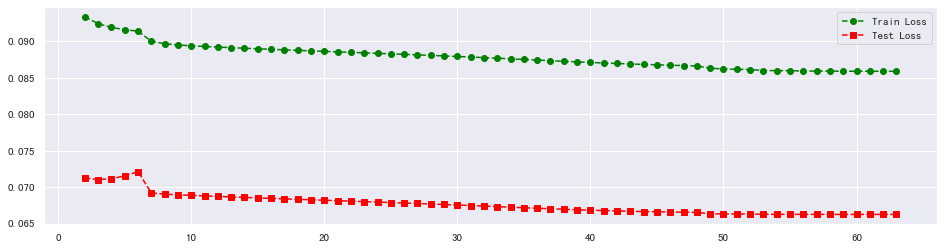

In [45]:
# 可视化LOSS曲线
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(16, 4))
x = list(range(len(train_loss)))
plt.plot(x[2:], train_loss[2:], 'o--g', label='Train Loss')
plt.plot(x[2:], val_loss[2:], 's--r', label='Test Loss')
plt.legend(loc='best')
plt.show()

In [46]:
# 呈现原始数据，训练结果，预测结果
def plot_img(all_true, train_pred, test_pred):
    plt.figure(figsize=(16, 8))
    all_x = list(range(len(all_true)))
    train_x = all_x[:len(train_pred)]
    test_x = all_x[-len(test_pred):]
    # 原始数据蓝色
    plt.scatter(all_x, all_true, marker='.', label='Real', c='#4285F4')
    # 训练数据橙色
    plt.scatter(train_x,
                train_pred,
                marker='.',
                label='Train Predict',
                c='#FBBC05')
    # 预测结果红色
    plt.scatter(test_x,
                test_pred,
                marker='.',
                label='Test Predict',
                c='#EA4335')
    plt.legend()
    plt.show()

In [47]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

In [48]:
train_pred.shape, test_pred.shape

((35039, 1), (8760, 1))

In [49]:
train_pred.min(), test_pred.min()

(-1.0710366, -0.9949685)

In [51]:
# 将预测值反归一化
train_pred_ = pollution_scaler.inverse_transform(train_pred)
test_pred_ = pollution_scaler.inverse_transform(test_pred)
# 将预测值限幅在0-994（pollution列的最大最小值）之间。
train_pred_ = np.clip(train_pred_, 0, 994)
test_pred_ = np.clip(test_pred_, 0, 994)

In [52]:
pd.DataFrame(train_pred_).describe()

,0
count,35039.000000
mean,93.323402
std,87.765724
min,0.000000
25%,25.809002
50%,67.662315
75%,131.272751
max,766.053040


In [53]:
pd.DataFrame(test_pred_).describe()

,0
count,8760.000000
mean,96.510475
std,89.515602
min,2.226460
25%,31.022303
50%,71.078270
75%,130.388401
max,601.616943


In [54]:
# 将归一化的真实值反归一化
all_true = pollution_scaler.inverse_transform(reframed[['var1(t)']])[:, 0]
pd.DataFrame(all_true).describe()

,0
count,43799.000000
mean,94.012717
std,92.253178
min,0.000000
25%,24.000000
50%,68.000000
75%,132.500000
max,994.000000


In [60]:
pd.DataFrame(y_pred).describe()

,0
count,43799.000000
mean,93.960831
std,88.126678
min,0.000000
25%,26.815079
50%,68.317612
75%,131.112389
max,766.053040


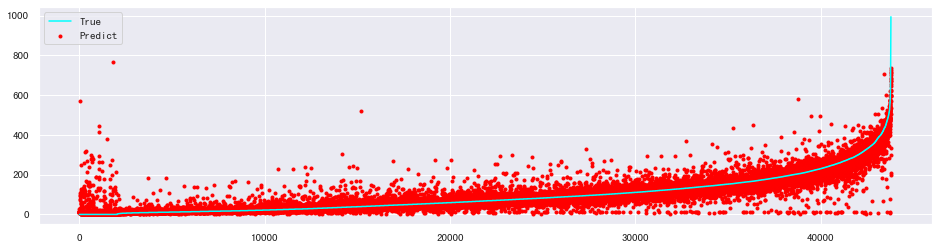

In [62]:
# 按真实值由小到大排序后真实值和预测值可视化
n = len(all_true)
plt.figure(figsize=(16, 4))
plt.scatter(range(n), y_pred[np.argsort(all_true), 0],c='r', marker='.',label='Predict')
plt.plot(range(n), np.sort(all_true),c='cyan', label='True')
plt.legend()

趋势相近，但误差较大